<a href="https://colab.research.google.com/github/heysourin/Customer-feedback-analysis/blob/main/Customer_feedback_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# !pip install -q kaggle

In [84]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [85]:
!kaggle datasets download -d sid321axn/amazon-alexa-reviews

Dataset URL: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews
License(s): other
amazon-alexa-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [86]:
from zipfile import ZipFile
dataset = '/content/amazon-alexa-reviews.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Data, extracted!")

Data, extracted!


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
df = pd.read_csv('/content/amazon_alexa.tsv', sep='\t')

In [89]:
df.shape

(3150, 5)

In [90]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [92]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rating,3150.0,NaN,NaN,NaN,4.463175,1.068506,1.0,4.0,5.0,5.0,5.0
date,3150,77,30-Jul-18,1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variation,3150,16,Black Dot,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verified_reviews,3149,2300,,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feedback,3150.0,NaN,NaN,NaN,0.918413,0.273778,0.0,1.0,1.0,1.0,1.0


In [93]:
df.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [94]:
# Checking for the numm value column
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [95]:
# Deleting the column with null value
df.dropna(inplace=True)

In [96]:
df.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [97]:
# Length col: creating for getting len(reviews)
df['length'] = df['verified_reviews'].apply(lambda x: len(x))

In [98]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [99]:
df.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64



<Axes: xlabel='rating', ylabel='Count'>

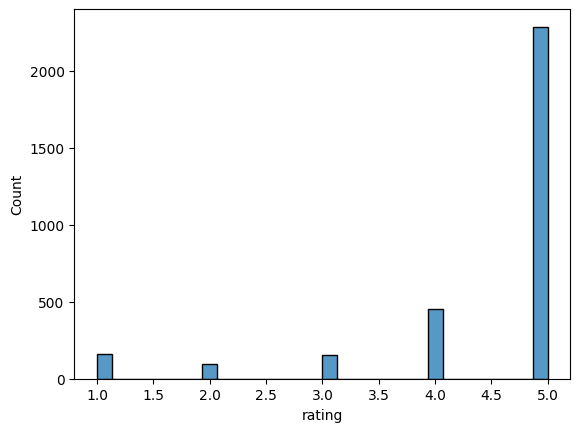

In [100]:
print(df['rating'].value_counts())
print()
print(round(df['rating'].value_counts()/df.shape[0]*100,2))
print()
sns.histplot(df['rating'])

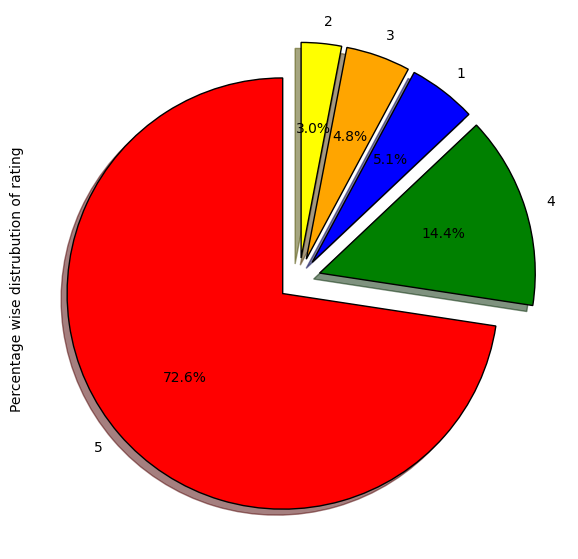

In [101]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['rating'].value_counts()/df.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

<Axes: xlabel='feedback', ylabel='Count'>

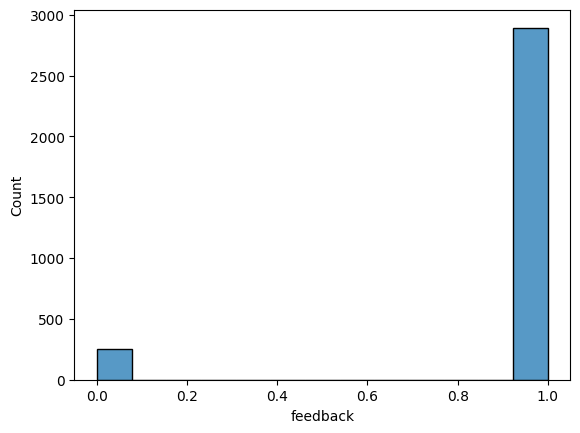

In [102]:
# Feedback count
df['feedback'].value_counts()
sns.histplot(df['feedback'])

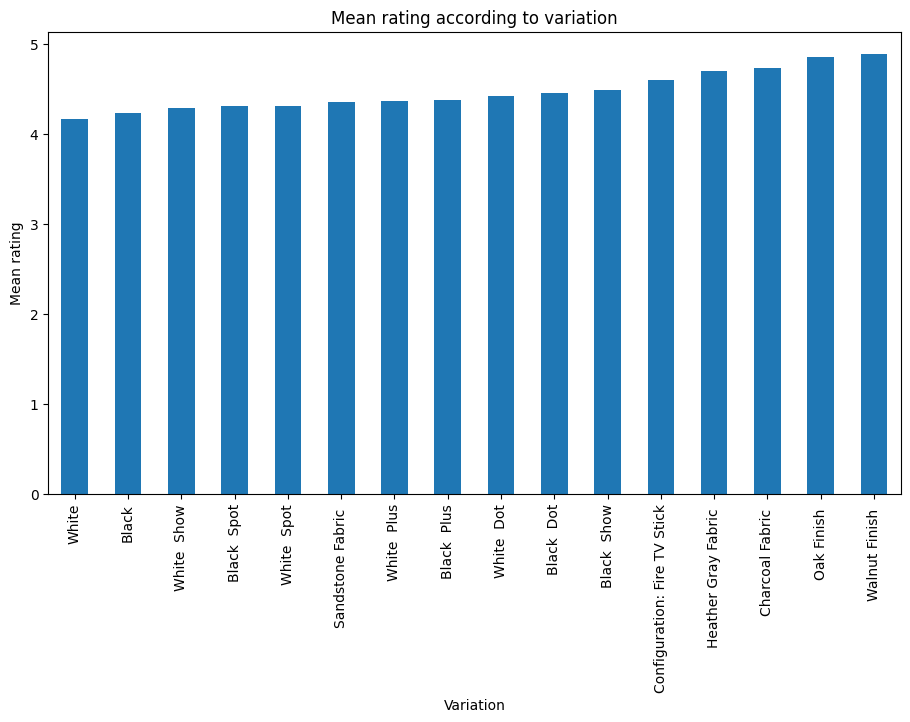

In [103]:
# Checking variance vs sells
df.groupby('variation')['rating'].mean().sort_values().plot.bar(figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

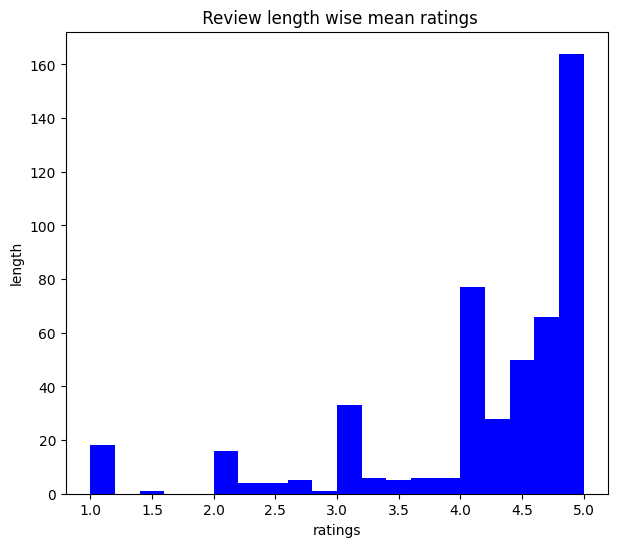

In [104]:
df.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

---
## **Count vectorizer:**

In [105]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

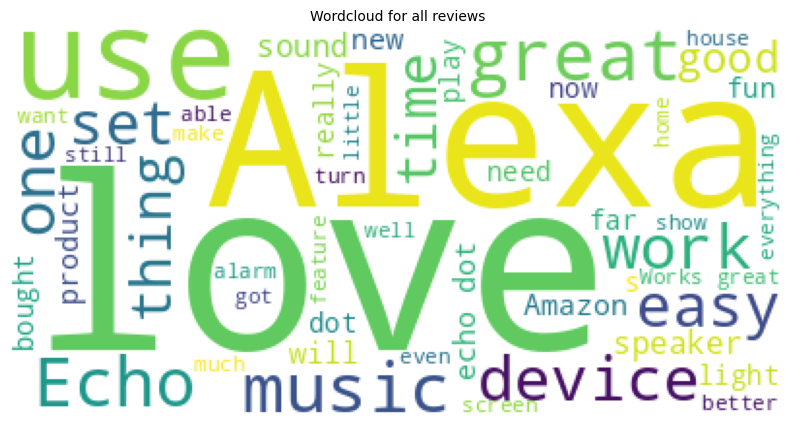

In [106]:
# Combine all reviews
reviews = " ".join([review for review in df['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

---
## **Training the model:**

In [107]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, len(df)):
  review = re.sub('[^a-zA-Z]', '', df.iloc[i]['verified_reviews'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in set(STOPWORDS)]
  review = ' '.join(review)
  corpus.append(review)

In [108]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [109]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [110]:
X.shape, y.shape

((3149, 2233), (3149,))

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2204, 2233), (945, 2233), (2204,), (945,))

In [112]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [113]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [114]:
# Random forest
rfc = RandomForestClassifier()
rfc.fit(X_train_scl, y_train)

RandomForestClassifier()

In [115]:
print("Training Accuracy :", rfc.score(X_train_scl, y_train))
print("Testing Accuracy :", rfc.score(X_test_scl, y_test))

Training Accuracy : 0.9936479128856625
Testing Accuracy : 0.9195767195767196


In [116]:
y_preds = rfc.predict(X_test_scl)

In [117]:
cm = confusion_matrix(y_test, y_preds)

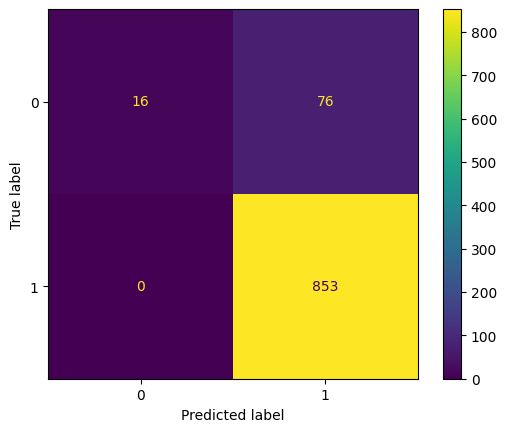

In [118]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
cm_display.plot()
plt.show()

In [119]:
# k-fold cross validation
accuracies = cross_val_score(estimator = rfc, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9337659399424105
Standard Variance : 0.00699965233408734


In [120]:
params = {
  'bootstrap': [True],
  'max_depth': [80, 100],
  'min_samples_split': [8, 12],
  'n_estimators': [100, 300]
}

In [121]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = rfc, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [122]:
# Getting the best parameters:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'min_samples_split': 12,
 'n_estimators': 300}

In [123]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.24546279491832
Cross validation mean accuracy on test set : 92.8255444646098
Accuracy score for test set : 0.9195767195767196


In [136]:
rfc_new= RandomForestClassifier(
  bootstrap=True,
  max_depth=100,
  min_samples_split=12,
  n_estimators=300,
  random_state=42  # Set a random state for reproducibility
)

In [137]:
rfc_new.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=12, n_estimators=300,
                       random_state=42)

In [138]:
y_pred = rfc_new.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

In [ ]:
#Saving the Random forest classifier
pickle.dump(rfc, open('Models/model_rfc.pkl', 'wb'))

---
## **XGBoost:**

In [124]:
# XGBoostClassifer
xgbc = XGBClassifier()
xgbc.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [125]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", xgbc.score(X_train_scl, y_train))
print("Testing Accuracy :", xgbc.score(X_test_scl, y_test))

Training Accuracy : 0.925589836660617
Testing Accuracy : 0.9026455026455027


In [126]:
y_preds = xgbc.predict(X_test)

In [127]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  0  92]
 [  0 853]]


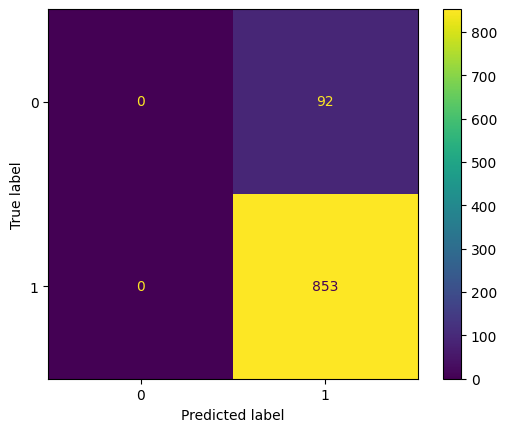

In [128]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgbc.classes_)
cm_display.plot()
plt.show()

In [129]:
#Saving the XGBoost classifier
pickle.dump(xgbc, open('Models/model_xgb.pkl', 'wb'))

In [130]:
#Decision tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [131]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", dtc.score(X_train_scl, y_train))
print("Testing Accuracy :", dtc.score(X_test_scl, y_test))

Training Accuracy : 0.9936479128856625
Testing Accuracy : 0.9195767195767196


In [132]:
y_preds = dtc.predict(X_test)

In [133]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 16  76]
 [  0 853]]


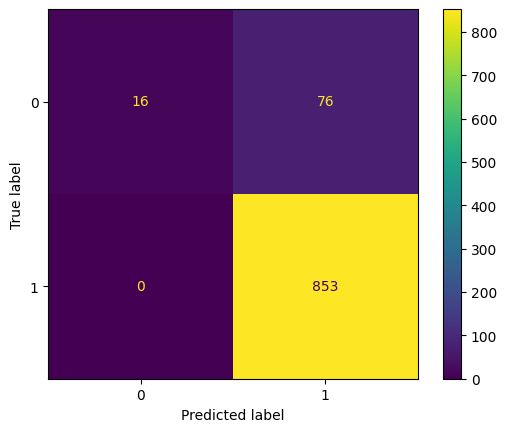

In [134]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtc.classes_)
cm_display.plot()
plt.show()

In [135]:
#Saving the decision tree classifier
pickle.dump(dtc, open('Models/model_dtc.pkl', 'wb'))